# Jupyter Example
## LAMMPS: Neb/in.neb.hop1
Reference: https://github.com/lammps/lammps/blob/master/examples/neb/in.neb.hop1  
Requied files: initial.hop1, final.hop1  
Description: 2d NEB surface simulation, hop from surface to become adatom

In [1]:
import os
import ipyparallel as ipp
rc = ipp.Client(profile='mpi')
view = rc[:]
print("Total number of MPI tasks =",len(view))

Total number of MPI tasks = 26


In [2]:
# Set file paths
task_dir=os.getcwd()+'/'
data_init=task_dir+"initial.hop1"
data_final=task_dir+"final.hop1"
infile=task_dir+"in.neb"
logfile=task_dir+"log.lammps"

# Create an empty input file (required by LAMMPS)
file=open(infile,'w')
file.close()

In [3]:
view['task_dir']=task_dir
view['logfile']=logfile
view['infile']=infile
view['data_init']=data_init
view['data_final']=data_final

## Initialize LAMMPS

In [4]:
%%capture
%%px
from mpi4py import MPI
from lammps import PyLammps
# Use 13 images with 2 MPI tasks per image
L = PyLammps(cmdargs=["-partition","13x2","-in",infile,"-log",logfile,"-plog","none","-pscreen","none"])

## Initial minimization

In [5]:
%%time
%%px

L.dimension("2")
L.boundary("p s p")

L.atom_style("atomic")
L.neighbor("0.3 bin")
L.neigh_modify("delay 5")
L.atom_modify("map array sort 0 0.0")

L.variable("u uloop 50 pad")

# create geometry with flat surface

L.lattice("hex 0.9")
L.region("box block 0 20 0 10 -0.25 0.25")
L.read_data(data_init)

# LJ potentials

L.pair_style("lj/cut 2.5")
L.pair_coeff("* * 1.0 1.0 2.5")
L.pair_modify("shift yes")

# initial minimization to relax surface

L.minimize("1.0e-6 1.0e-4 1000 10000")
L.reset_timestep("0")

CPU times: user 55.2 ms, sys: 916 µs, total: 56.1 ms
Wall time: 53.2 ms


## Nudged-elastic band calculation

In [6]:
%%time
%%px

# define groups

L.region("1 block INF INF INF 1.25 INF INF")
L.group("lower region 1")
L.group("mobile subtract all lower")
L.set("group lower type 2")

L.timestep("0.05")

# group of NEB atoms - either block or single atom ID 412

L.region("surround block 10 18 17 20 0 0 units box")
L.group("nebatoms region surround")
#L.group("nebatoms id 412")
L.set("group nebatoms type 3")
L.group("nonneb subtract all nebatoms")

L.fix("1 lower setforce 0.0 0.0 0.0")
L.fix("2 nebatoms neb 1.0 parallel ideal")
L.fix("3 all enforce2d")

L.thermo(100)

# run NEB

L.min_style("quickmin")
L.neb("0.0 0.01 1000 1000 10 final", data_final)

# Dump images of final structures 

L.dump(1,"all","image",1,task_dir+"neb.*.$u.jpg","type","type","zoom",1.6,"adiam",1.2,"up",0,1,0,"box","yes",0)
L.dump_modify(1,"pad",2)
L.run(0)

CPU times: user 53.2 ms, sys: 4.02 ms, total: 57.2 ms
Wall time: 224 ms


## Visualize MEP (scatter plot)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
header=['Step','MaxReplicaForce','MaxAtomForce','GradV0','GradV1','GradVc','EBF','EBR','RDT','RD1','PE1','RD2','PE2','RD3','PE3','RD4','PE4','RD5','PE5','RD6','PE6','RD7','PE7','RD8','PE8','RD9','PE9','RD10','PE10','RD11','PE11','RD12','PE12','RD13','PE13']

# Load NEB results from log.lammps
df=pd.read_csv("log.lammps", delim_whitespace=True,skiprows=97,names=header)
df

,Step,MaxReplicaForce,MaxAtomForce,GradV0,GradV1,GradVc,EBF,EBR,RDT,RD1,...,RD9,PE9,RD10,PE10,RD11,PE11,RD12,PE12,RD13,PE13
0,901,0.025614,0.024015,0.000199,0.000438,0.025593,0.007111,0.002293,2.503412,0,...,0.666547,-3.046545,0.749823,-3.046794,0.833095,-3.047415,0.916384,-3.048462,1,-3.048778
1,911,0.042027,0.021976,0.000188,0.000424,0.024430,0.007111,0.002293,2.503655,0,...,0.666583,-3.046545,0.749852,-3.046794,0.833117,-3.047416,0.916399,-3.048462,1,-3.048778
2,921,0.022041,0.020161,0.000181,0.000414,0.021715,0.007112,0.002293,2.503839,0,...,0.666675,-3.046546,0.749923,-3.046794,0.833166,-3.047417,0.916425,-3.048463,1,-3.048778
3,931,0.031473,0.018828,0.000172,0.000402,0.022047,0.007112,0.002293,2.504040,0,...,0.666833,-3.046546,0.750043,-3.046795,0.833248,-3.047418,0.916467,-3.048464,1,-3.048778
4,941,0.018752,0.017301,0.000165,0.000393,0.018450,0.007112,0.002293,2.504202,0,...,0.666997,-3.046546,0.750167,-3.046796,0.833332,-3.047419,0.916511,-3.048465,1,-3.048778
5,951,0.016991,0.015909,0.000158,0.000384,0.016938,0.007112,0.002293,2.504379,0,...,0.667208,-3.046546,0.750326,-3.046797,0.833440,-3.047421,0.916567,-3.048466,1,-3.048778
6,961,0.015612,0.014508,0.000150,0.000373,0.015461,0.007112,0.002293,2.504568,0,...,0.667464,-3.046547,0.750520,-3.046798,0.833571,-3.047423,0.916634,-3.048467,1,-3.048778
7,971,0.014382,0.013354,0.000143,0.000364,0.014209,0.007112,0.002293,2.504740,0,...,0.667719,-3.046547,0.750712,-3.046799,0.833701,-3.047425,0.916702,-3.048468,1,-3.048778
8,981,0.026288,0.012073,0.000137,0.000355,0.015062,0.007112,0.002293,2.504897,0,...,0.667966,-3.046548,0.750899,-3.046800,0.833828,-3.047426,0.916768,-3.048469,1,-3.048778
9,991,0.012511,0.011434,0.000132,0.000347,0.012174,0.007112,0.002293,2.505039,0,...,0.668197,-3.046548,0.751073,-3.046801,0.833946,-3.047428,0.916829,-3.048470,1,-3.048778


In [9]:
x=df.iloc[[14],9:35:2].values[0].tolist()
y=df.iloc[[14],10:36:2].values[0].tolist()

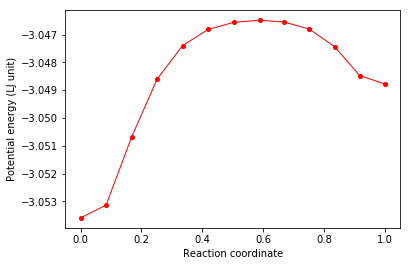

In [10]:
plt.plot(x,y,'ro',linestyle='solid', linewidth=1, markersize=4)
plt.xlabel("Reaction coordinate")
plt.ylabel("Potential energy (LJ unit)")
plt.show()

In [11]:
# Forward and Reverse enegy barrier
print("Index of maximum energy image =",np.argmax(y))
print("Forward energy barrier =",df['EBF'][14])
print("Reverse energy barrier =",df['EBR'][14])

Index of maximum energy image = 7
Forward energy barrier = 0.0071118818999999995
Reverse energy barrier = 0.0022931414


## Visualize MEP (movie)

In [12]:
%%capture
# Use ffmpeg to make mp4 movie
!cat *.jpg | ffmpeg -y -f image2pipe -c:v mjpeg -i - -b:v 2000k -vcodec libx264 -pix_fmt yuv420p neb.mp4;

In [13]:
%%HTML
<video width="320" height="320" controls>
  <source src="neb.mp4" type="video/mp4">
</video>